(supervised:ann:ann-keras)=
# ANNs with Keras

To represent complex hypotheses with ANNs we need thousands or even millions of artificial neurons. ANNs with few large layers turned out be less effective than ANNs with many smaller layers. The latter are referred to as *deep networks* and their usage is known as *deep learning*.

Training ANNs requires lots of computation time for large data sets and large networks. Thus, we need efficient implementations of learning procedures and powerful hardware. Scikit-Learn aims at educational projects and offers a wide scale of machine learning methods. Implementation is less optimized for execution speed than for providing insight into the algorithms and providing access to all the parameters and intermediate results. Further, Scikit-Learn does not use all features of modern hardware.

Libraries for high-performance machine learning have to be more specialized on specific tasks to allow for optimizing efficiency. [Keras](https://keras.io) is an open source library for implementing and training ANNs. Like Scikit-Learn it provides preprocessing routines as well as postprocessing (optimizing hyperparameters). But Keras utilizes full computation power of modern computers for training ANNs, leading to much shorter training times.

Modern computers have multi-core CPUs. So they can process several programs in parallel. In addition, almost all computers have a powerful GPU (graphics processing unit). It's like a second CPU specialized at doing floating point computations for rendering 3d graphics. GPUs are much more suited for training ANNs than CPUs, because they are designed to work with many large matrices of floating point numbers in parallel. Nowadays GPUs can be accessed by software developers relatively easily. Thus, we may run programs on the GPU instead of the CPU.

Keras seamlessly integrates GPU power for ANN training into Python. We do not have to care about the details. Keras piggybacks on an open source library called [TensorFlow](https://www.tensorflow.org/) developed by Google. Keras does much of the work for us, but from time to time TensorFlow will show up, too. Keras started independently from TensorFlow, then integrated support for TensorFlow, and now is distributed as a module in the TensorFlow Python package.

In [1]:
import tensorflow.keras as keras

2023-04-25 10:26:31.847362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## An ANN for Handwritten Digit Recognition

To demonstrate usage of Keras we implement and train a layered feedforward ANN to classify handwritten digits from the QMNIST data set. Inputs to the ANN are images of size 28x28. Thus, the feature space has dimension 784. Outputs are 10 real numbers in $[0,1]$. Each number represents the probability that the image shows the corresponding digit.

We could also use an ANN with only one output and require that this output is the digit, that is, it has range $[0,9]$. But how to interpret an output of 3.5? It suggests that the ANN cannot decide between 3 and 4. Or it might waffle on 2 and 5. Using only one output we would introduce artificial order and, thus, wrong similarity assumptions. From the view of similarity of shape (and only that matters in digit recognition), 3 and 8 are more close to each other than 7 and 8 are. Using one output per figure we avoid artificial assumptions and get more precise information on possible missclassifications. Images with high outputs for both 1 and 7 could be marked for subsequent review by a human, for example

### Loading Data

For loading QMNIST data we may reuse code from [](projects:mnist:load-qmnist) project. We have to load training data and test data, both consisting of 60000 images and corresponding labels.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import qmnist

In [3]:
train_images, train_labels, _, _ = qmnist.load('../../../../datasets/qmnist/', subset='train')
test_images, test_labels, _, _ = qmnist.load('../../../../datasets/qmnist/', subset='test')

In [4]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 28, 28), (60000, 28, 28), (60000,), (60000,))

In [5]:
train_images[0, :, :].min(), train_images[0, :, :].max()

(0.0, 1.0)

For visualization of data we use a gray scale with black at smallest value and white at highest value.

In [6]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(img, vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    plt.show()

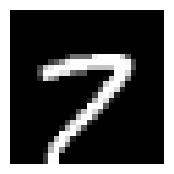

label: 7


In [7]:
idx = 123

show_image(train_images[idx, :, :])
print('label:', train_labels[idx])

### Preprocessing

Input to an ANN should be standardized or normalized. QMNIST images have range $[0, 1]$. That's okay.

Optionally, we may center the images with respect to a figure's bounding box. Without this step the center of mass is identical to the image center (we may reuse code from [](exercises:managing-data:image-processing)). As a by-product of centering bounding boxes each image will have 4 unused pixels at the boundary. Thus, we may crop images to 20x20 pixels without loss of information (resulting in 400 instead of 784 features).

In [8]:
def auto_crop(img):

    # binarize image
    mask = img > 0

    # whole image black?
    if not mask.any():
        return np.array([])
    
    # get top and bottom index of bounding box
    row_mask = mask.any(axis=1)
    top = np.argmax(row_mask)
    bottom = row_mask.size - np.argmax(row_mask[::-1])    # bottom index + 1
    
    # get left and right index of bounding box
    col_mask = mask[top:bottom, :].any(axis=0)    # [top:bottom, :] for efficiency only
    left = np.argmax(col_mask)
    right = col_mask.size - np.argmax(col_mask[::-1])    # right index + 1
    
    # crop
    return img[top:bottom, left:right].copy()


def center(img, n):

    # check image size
    if np.max(img.shape) > n:
        print('n too small! Cropping image.')
        img = img[0:np.minimum(n, img.shape[0]), 0:np.minimum(n, img.shape[1])]
        
    # calculate margin width
    top_margin = (n - img.shape[0]) // 2
    left_margin = (n - img.shape[1]) // 2
    
    # create image
    img_new = np.zeros((n, n), dtype=img.dtype)
    img_new[top_margin:(top_margin + img.shape[0]),
            left_margin:(left_margin + img.shape[1])] = img
            
    return img_new

In [9]:
train_images = qmnist.preprocess(train_images, [auto_crop, lambda img: center(img, 20)])
test_images = qmnist.preprocess(test_images, [auto_crop, lambda img: center(img, 20)])

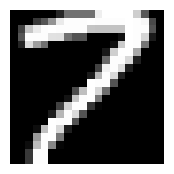

label: 7


In [10]:
idx = 123

show_image(train_images[idx, :, :])
print('label:', train_labels[idx])

Training labels have to be one-hot encoded. This can be done manually with NumPy or automatically with Pandas or Scikit-Learn. Also Keras provides a function for one-hot encoding: [`to_categorical`](https://keras.io/api/utils/python_utils/#tocategorical-function).

In [11]:
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

train_labels.shape, test_labels.shape

((60000, 10), (60000, 10))

### Defining the ANN

Keras has a [`Model`](https://keras.io/api/models/model/) class representing a directed graph of layers of neurons. At the moment we content ourselves with simple network structures, that is, we have a sequence of layers. For such simple structures Keras has the [`Sequential`](https://keras.io/api/models/sequential/) class. That class represents a stack of layers of neurons. It's a subclass of `Model`.

A layer is represented by one of several layer classes in Keras. For a fully connected feedforward ANN we need an [`Input`](https://keras.io/api/layers/core_layers/input/) layer and several [`Dense`](https://keras.io/api/layers/core_layers/dense/) layers. Layers can be added one by one with [`Sequential.add`](https://keras.io/api/models/sequential/#add-method).

`Input` layers accept multi-dimensional inputs. Thus, we do not have to convert the 20x20 images to vectors with 400 components. But `Dense` layers want to have one-dimensional input. Thus, we use a [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) layer. Like the `Input` layer that's not a layer of neurons. Layers in Keras have to be understood as transformations taking some input and yielding some output. For `Dense` layers we need to specify the number of neurons and the activation function to use. There are several [pre-defined activation functions](https://keras.io/api/layers/activations/) in Keras.

Layers may have a name, which will help accessing single layers for analysis of a trained model. If we do not specify layer names, Keras generates them automatically.

In [12]:
model = keras.Sequential()

model.add(keras.Input(shape=(20, 20)))
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(10, activation='relu', name='dense1'))
model.add(keras.layers.Dense(10, activation='relu', name='dense2'))

2023-04-25 10:26:40.248000: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-04-25 10:26:40.248032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: WHZ-46349
2023-04-25 10:26:40.248039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: WHZ-46349
2023-04-25 10:26:40.248184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-04-25 10:26:40.248204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-04-25 10:26:40.248209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-04-25 10:26:40.248864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Networ

The output layer is a `Dense` layer with 10 neurons. Because all outputs shall have range [0,1] we use the sigmoid function.

In [13]:
model.add(keras.layers.Dense(10, activation='sigmoid', name='out'))

Output shape can be accessed via corresponding member variable:

In [14]:
model.output_shape

(None, 10)

Almost always the first dimension of input or output shapes is the batch size for mini-batch training in Keras. `None` is used, if there is no fixed batch size.

More detailed information about the constructed ANN is provided by `Sequential.summary`:

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense1 (Dense)              (None, 10)                4010      
                                                                 
 dense2 (Dense)              (None, 10)                110       
                                                                 
 out (Dense)                 (None, 10)                110       
                                                                 
Total params: 4,230
Trainable params: 4,230
Non-trainable params: 0
_________________________________________________________________


### Training the ANN

Parameters for training are set with [`Model.compile`](https://keras.io/api/models/model_training_apis/#compile-method). Here we may define an optimization routine. Next to gradient descent there are several other [optimizers available](https://keras.io/api/optimizers/#available-optimizers). The optimizer can be passed by name (as string) or we may create a Python object of the respective optimizer class. The latter allows for custom parameter choice.

Next to the optimizer we have to provide a [loss function](https://keras.io/api/losses/#available-losses). Again we may pass a string or an object. Because we have a classification problem we may use log loss.

If we want to validate the model during training, we may pass validation [metrics](https://keras.io/api/metrics/) to `compile`. Then output during training includes updated values for the validation metrics on training and validation data. For classification we may use accuracy score. Again, metrics can be passsed by name or as an object. Since we might wish to compute several different metrics, the `metrics` argument expects a list.

In [16]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Now the model is ready for training. In Keras training is done by calling [`Model.fit`](https://keras.io/api/models/model_training_apis/#fit-method). We may specify the batch size for mini-batch training and the number of *epochs*. An epoch is a sequence of iterations required to cycle through the training data once. Small batch sizes require more iterations per epoch, large batch sizes require fewer iterations. In full-batch training epochs and iterations are equivalent. We may also specify validation data (directly or as fraction of the training data) to get validation metrics after each epoch. Thus, we can see wether the model overfits the data during training and abort training if necessary. The return value of `fit` will be discussed below.

In [17]:
history = model.fit(train_images, train_labels, batch_size=100, epochs=5, validation_split=0.2)

Epoch 1/5
480/480 [==============================] - 1s 2ms/step - loss: 2.0348 - categorical_accuracy: 0.3197 - val_loss: 1.6531 - val_categorical_accuracy: 0.4880
Epoch 2/5
480/480 [==============================] - 1s 1ms/step - loss: 1.2421 - categorical_accuracy: 0.6128 - val_loss: 0.8575 - val_categorical_accuracy: 0.7488
Epoch 3/5
480/480 [==============================] - 1s 1ms/step - loss: 0.7235 - categorical_accuracy: 0.7898 - val_loss: 0.5639 - val_categorical_accuracy: 0.8444
Epoch 4/5
480/480 [==============================] - 1s 1ms/step - loss: 0.5463 - categorical_accuracy: 0.8456 - val_loss: 0.4627 - val_categorical_accuracy: 0.8720
Epoch 5/5
480/480 [==============================] - 1s 1ms/step - loss: 0.4769 - categorical_accuracy: 0.8661 - val_loss: 0.4172 - val_categorical_accuracy: 0.8847


```{hint}
Note that validation accuracy displayed by Keras sometimes is higher than training accuracy. The reason is that train accuracy is the mean over all iterations of an epoche, but validation accuracy is calulated only at the end of an epoche. Thus, training accuracy includes poorer accuracy values from beginning of an epoche.
```

### Incremental Training

The `Model.fit` method returns a `History` object containing information about loss and metrics for each training epoch. The object has a dict member `history` containing losses and metrics. Loss keys are `loss` and `val_loss` for training and validation, respectively. Metrics keys depend an the chosen metrics.

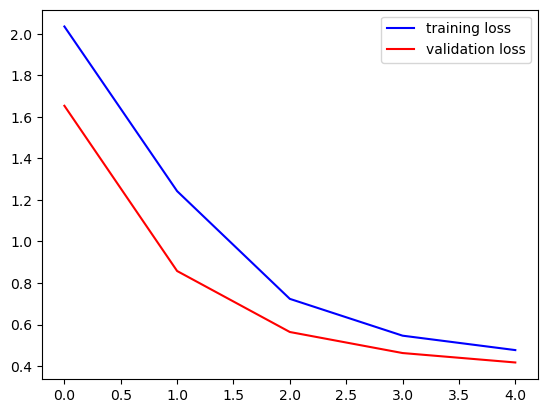

In [18]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], '-b', label='training loss')
ax.plot(history.history['val_loss'], '-r', label='validation loss')
ax.legend()
plt.show()

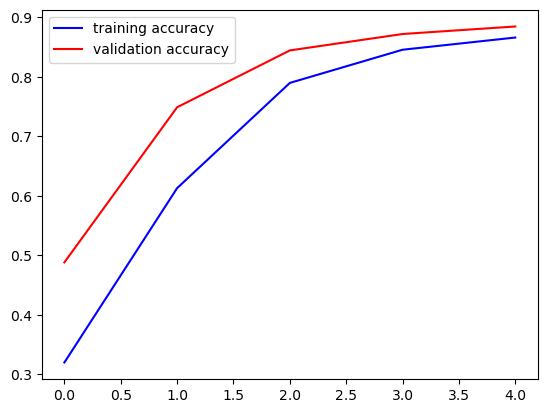

In [19]:
fig, ax = plt.subplots()
ax.plot(history.history['categorical_accuracy'], '-b', label='training accuracy')
ax.plot(history.history['val_categorical_accuracy'], '-r', label='validation accuracy')
ax.legend()
plt.show()

We see that further training could improve the model. Thus, we call `fit` again. Training proceeds from where it has been stopped. We may execute corresponding code cell as often as we like to continue training. To keep the losses and metrics we append them to lists.

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

In [21]:
history = model.fit(train_images, train_labels, batch_size=100, epochs=5, validation_split=0.2)

loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])
acc.extend(history.history['categorical_accuracy'])
val_acc.extend(history.history['val_categorical_accuracy'])

Epoch 1/5
480/480 [==============================] - 1s 1ms/step - loss: 0.4419 - categorical_accuracy: 0.8773 - val_loss: 0.3943 - val_categorical_accuracy: 0.8908
Epoch 2/5
480/480 [==============================] - 1s 1ms/step - loss: 0.4203 - categorical_accuracy: 0.8845 - val_loss: 0.3797 - val_categorical_accuracy: 0.8942
Epoch 3/5
480/480 [==============================] - 1s 1ms/step - loss: 0.4045 - categorical_accuracy: 0.8891 - val_loss: 0.3674 - val_categorical_accuracy: 0.8992
Epoch 4/5
480/480 [==============================] - 1s 1ms/step - loss: 0.3920 - categorical_accuracy: 0.8930 - val_loss: 0.3564 - val_categorical_accuracy: 0.8999
Epoch 5/5
480/480 [==============================] - 1s 1ms/step - loss: 0.3813 - categorical_accuracy: 0.8954 - val_loss: 0.3486 - val_categorical_accuracy: 0.9016


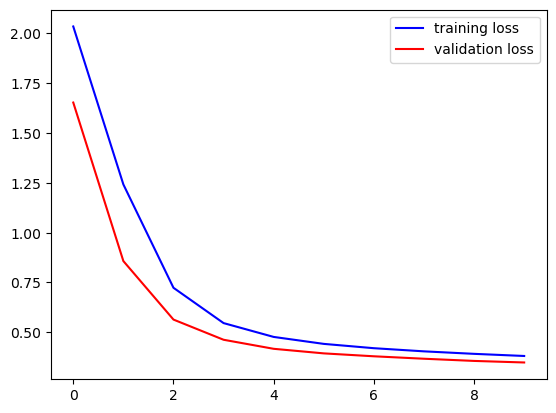

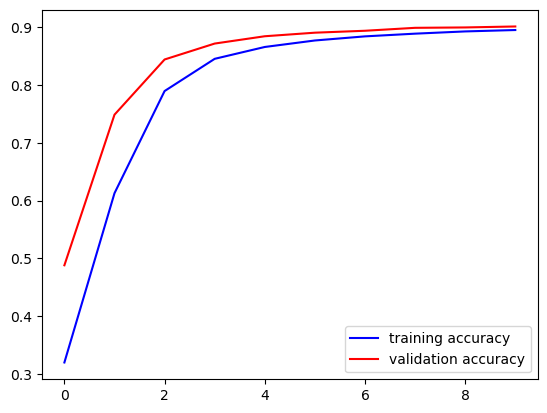

In [22]:
fig, ax = plt.subplots()
ax.plot(loss, '-b', label='training loss')
ax.plot(val_loss, '-r', label='validation loss')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(acc, '-b', label='training accuracy')
ax.plot(val_acc, '-r', label='validation accuracy')
ax.legend()
plt.show()

### Evaluation and Prediction

To get loss and metrics on the test set call [`Model.evaluate`](https://keras.io/api/models/model_training_apis/#evaluate-method).

In [23]:
test_loss, test_metric = model.evaluate(test_images, test_labels)

test_loss, test_metric

1875/1875 [==============================] - 2s 968us/step - loss: 0.3572 - categorical_accuracy: 0.9006


(0.3571886718273163, 0.9005666375160217)

For predictions call [`Model.predict`](https://keras.io/api/models/model_training_apis/#predict-method).

In [24]:
test_pred = model.predict(test_images)

1875/1875 [==============================] - 1s 710us/step


Predictions are vectors of values from $[0, 1]$. A one indicates that the image shows the corresponding digit, a zero indicates that the digits is not shown in the image.

truth:      [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction: [0.01495721 0.9989413  0.81571907 0.9306395  0.24000315 0.67344236
 0.7693644  0.39637503 0.88925314 0.50644916]


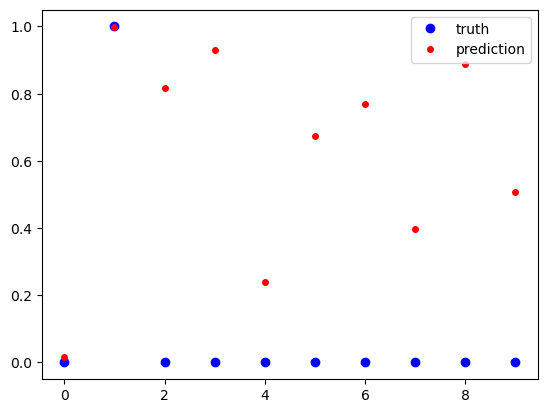

In [25]:
idx = 2

print('truth:     ', test_labels[idx, :])
print('prediction:', test_pred[idx, :])

fig, ax = plt.subplots()
ax.plot(test_labels[idx, :], 'ob', label='truth')
ax.plot(test_pred[idx, :], 'or', markersize=4, label='prediction')
ax.legend()
plt.show()

To get more insight into the prediction accuracy we reverse one-hot encoding.

In [26]:
true_digits = test_labels.argmax(axis=1)
pred_digits = test_pred.argmax(axis=1)

# indices with wrong predictions
wrong_predictions = np.arange(0, true_digits.size)[true_digits != pred_digits]
print(wrong_predictions.size)
print(wrong_predictions)

5987
[    8    18    33 ... 59974 59998 59999]


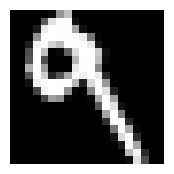

truth: 9, prediction: 9


In [27]:
idx = 7
    
show_image(test_images[idx])

print('truth: {}, prediction: {}'.format(true_digits[idx], pred_digits[idx]))

A *confusion matrix* depicts which digits are hard to separate for the ANN. The matrix is 10x10. The entry at row $i$ and column $j$ gives the number of images which show digit $i$ (truth), but corresponding prediction is $j$. Several Python modules provide functions for building a confusion matrix. Next to Scikit-Learn we may use Pandas for getting the matrix and Seaborn for plotting ([`pd.crosstab`](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html), [`sns.heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html)).

In [28]:
conf_matrix = pd.crosstab(pd.Series(true_digits, name='truth'),
                          pd.Series(pred_digits, name='prediction'))
print(conf_matrix)

prediction     0     1     2     3     4     5     6     7     8     9
truth                                                                 
0           5591     3    35    26    41    71    74     8    97     6
1              1  6448    26    54     9    91    31    13    94    24
2             66    58  5374    94    54    29   136    66   139    10
3             23    22   147  5405     6   218     6    90   120    47
4             21    57    24     2  5183     8   132     2    33   318
5             46    38    43   253   125  4637    51    34   184    43
6             72    37    73     1    35    80  5618     0    41     0
7              6    41    41    28    31    16     1  5654    28   385
8             40   214    98   105   106   276    19    66  4883    83
9             20    33     3    79   150    43     1   200    86  5220


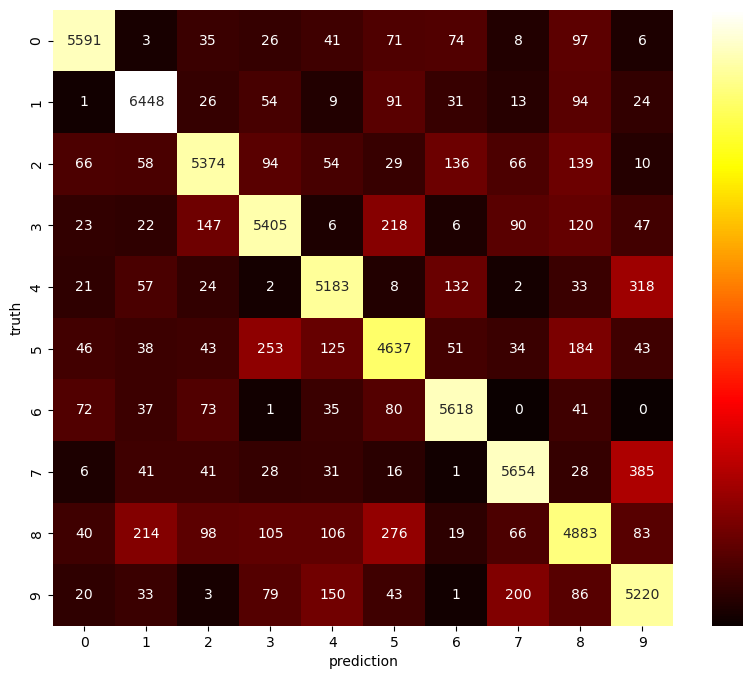

In [29]:
# scale values nonlinearly to get different colors at small values
scaled_conf_matrix = conf_matrix.apply(lambda x: x ** (1/2))

fig = plt.figure(figsize=(10, 8))
sns.heatmap(scaled_conf_matrix,
            annot=conf_matrix,    # use original matrix for labels
            fmt='d',    # format numbers as integers
            cmap='hot',    # color map
            cbar_kws={'ticks': []})    # no ticks for colorbar (would have scaled labels)
plt.show()

## Hyperparameter Optimization

Keras itself offers no hyperparameter optimization routines. But there is the [`keras-tuner`](https://keras-team.github.io/keras-tuner/) module (import as `keras_tuner`).

In [30]:
import keras_tuner

We first have to create a function which builds the model and returns a `Model` instance. This function takes a [`HyperParameters`](https://keras-team.github.io/keras-tuner/documentation/hyperparameters/) object as argument containing information about hyperparameters to optimize. The build function calls methods of the `HyperParameters` object to get values from the current set of hyperparameters.

In [31]:
def build_model(hp):
    
    model = keras.Sequential()
    model.add(keras.Input(shape=(20, 20)))
    model.add(keras.layers.Flatten())

    layers = hp.Int('layers', 1, 3)
    neurons_per_layer = hp.Int('neurons_per_layer', 10, 40, step=10)
    
    for l in range(0, layers):
        model.add(keras.layers.Dense(neurons_per_layer, activation='relu'))

    model.add(keras.layers.Dense(10, activation='sigmoid'))

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

Now we create a [`Tuner`](https://keras-team.github.io/keras-tuner/documentation/tuners/) object and call its [`search`](https://keras.io/api/keras_tuner/tuners/base_tuner/#search-method) method. Several subclasses are available. [`RandomSearch`](https://keras.io/api/keras_tuner/tuners/random/#randomsearch-class) randomly selects sets of hyperparameters and trains the model for each set of hyperparameters. The constructor takes the model building function, an objective (string with objective name of one of the model's metrics), and the maximum number of parameter sets to test. The `search` function takes training and validation data in full analogy to `fit`.

In [32]:
tuner = keras_tuner.tuners.randomsearch.RandomSearch(build_model, 'val_categorical_accuracy', 10)
tuner.search(train_images, train_labels, validation_split=0.2, epochs=10)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


Here is a summary of all models considered during hyperparameter optimization:

In [33]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_categorical_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
layers: 3
neurons_per_layer: 30
Score: 0.9556666612625122

Trial 02 summary
Hyperparameters:
layers: 2
neurons_per_layer: 30
Score: 0.9505000114440918

Trial 08 summary
Hyperparameters:
layers: 2
neurons_per_layer: 40
Score: 0.9503333568572998

Trial 05 summary
Hyperparameters:
layers: 2
neurons_per_layer: 20
Score: 0.9451666474342346

Trial 04 summary
Hyperparameters:
layers: 3
neurons_per_layer: 20
Score: 0.9445000290870667

Trial 01 summary
Hyperparameters:
layers: 1
neurons_per_layer: 40
Score: 0.9440000057220459

Trial 06 summary
Hyperparameters:
layers: 1
neurons_per_layer: 30
Score: 0.9401666522026062

Trial 07 summary
Hyperparameters:
layers: 1
neurons_per_layer: 20
Score: 0.9340833425521851

Trial 03 summary
Hyperparameters:
layers: 1
neurons_per_layer: 10
Score: 0.922249972820282

Trial 00 summary
Hyperparameters:


To get the best model we may call [`Tuner.get_best_models`](https://keras.io/api/keras_tuner/tuners/base_tuner/#get_best_models-method), which returns a sorted (best first) list of trained `Model` instances. Alternatively, we may call [`Tuner.get_best_hyperparameters`](https://keras.io/api/keras_tuner/tuners/base_tuner/#get_best_hyperparameters-method) returning a list of `HyperParameter` objects of the best models. Based on the best hyperparameters we may train corresponding model on the full data set to improve results. Both methods take an argument specifying the number of models to return and defaulting to 1.

In [34]:
best_hp = tuner.get_best_hyperparameters()[0]
best_model = build_model(best_hp)
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense (Dense)               (None, 30)                12030     
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 10)                310       
                                                                 
Total params: 14,200
Trainable params: 14,200
Non-trainable params: 0
_________________________________________________________________


In [35]:
best_model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7758 - categorical_accuracy: 0.7655
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3384 - categorical_accuracy: 0.9027
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2765 - categorical_accuracy: 0.9202
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2381 - categorical_accuracy: 0.9314
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2127 - categorical_accuracy: 0.9384
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1937 - categorical_accuracy: 0.9430
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1786 - categorical_accuracy: 0.9478
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1668 - categorical_accuracy: 0.9514
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1571 - cat

In [36]:
test_loss, test_metric = best_model.evaluate(test_images, test_labels)

test_loss, test_metric

1875/1875 [==============================] - 2s 1000us/step - loss: 0.1729 - categorical_accuracy: 0.9482


(0.17285792529582977, 0.948199987411499)

## Stopping Criteria

So far we stopped training after a fixed number of epochs. But Keras also implements a mechanism for stopping training if loss or metrics stop improving.  That mechanism is denoted as [`callbacks`](https://keras.io/api/callbacks/). We simply have to create a suitable `Callback` object and pass it to the fit method. Stopping criteria can be implemented with [`EarlyStopping`](https://keras.io/api/callbacks/early_stopping/) objects (it's a subclass of `Callback`). If we want to stop training if the validation loss starts to increase for at least 3 consecutive epochs, we have to pass `monitor='val_loss'`, `mode='min'`, `patience=3`, `restore_best_weights=True`. The last argument tells the `fit` method to not return the final model, but the best model.

In [37]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
best_model.fit(train_images, train_labels, validation_split=0.2, epochs=1000, callbacks=[es])

Epoch 1/1000
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1421 - categorical_accuracy: 0.9586 - val_loss: 0.1316 - val_categorical_accuracy: 0.9625
Epoch 2/1000
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1361 - categorical_accuracy: 0.9603 - val_loss: 0.1337 - val_categorical_accuracy: 0.9603
Epoch 3/1000
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1307 - categorical_accuracy: 0.9615 - val_loss: 0.1365 - val_categorical_accuracy: 0.9598
Epoch 4/1000
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1250 - categorical_accuracy: 0.9633 - val_loss: 0.1283 - val_categorical_accuracy: 0.9613
Epoch 5/1000
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1196 - categorical_accuracy: 0.9649 - val_loss: 0.1277 - val_categorical_accuracy: 0.9620
Epoch 6/1000
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1153 - categorical_accuracy: 0.9659 - val_loss: 0.1260 - val_categoric

Resulting accuracy on test set:

In [38]:
test_loss, test_metric = best_model.evaluate(test_images, test_labels)
test_loss, test_metric

1875/1875 [==============================] - 2s 1ms/step - loss: 0.1479 - categorical_accuracy: 0.9562


(0.14791476726531982, 0.9561833143234253)

## Saving and Loading Models

Keras models provide a [`save`](https://keras.io/api/models/model_saving_apis/model_saving_and_loading/#save-method) to a model to a file. To load a model use [`load_model`](https://keras.io/api/models/model_saving_apis/model_saving_and_loading/#load_model-function).

In [39]:
best_model.save('keras_save_best_model.keras')

INFO:tensorflow:Assets written to: keras_save_best_model/assets


INFO:tensorflow:Assets written to: keras_save_best_model/assets


In [40]:
model = keras.models.load_model('keras_save_best_model.keras')

## Visualization of Training Progress

TensorFlow comes with a visualization tool called TensorBoard. It uses a web interface for visualizing training dynamics and it can be integrated into Jupyter notebooks.

To use TensorBoard we have to pass a [`TensorBoard`](https://keras.io/api/callbacks/tensorboard/) callback to `fit`. Corresponding constructor takes a path to a directory for storing temporary training data. Running
```
tensorboard --logdir=path/to/directory
```
in the terminal will show an URL to access the TensorBoard interface within a web browser.

To use TensorBoard inside a Jupyter Notebook, execute the magic commands
```
%load_ext tensorboard
%tensorboard --logdir path/to/directory
```

In [41]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
tb = keras.callbacks.TensorBoard('tensorboard_data')
best_model.fit(train_images, train_labels, validation_split=0.2, epochs=1000, callbacks=[es, tb])

Epoch 1/1000
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1106 - categorical_accuracy: 0.9669 - val_loss: 0.1313 - val_categorical_accuracy: 0.9596
Epoch 2/1000
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1069 - categorical_accuracy: 0.9683 - val_loss: 0.1273 - val_categorical_accuracy: 0.9618
Epoch 3/1000
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1036 - categorical_accuracy: 0.9689 - val_loss: 0.1255 - val_categorical_accuracy: 0.9626
Epoch 4/1000
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0994 - categorical_accuracy: 0.9700 - val_loss: 0.1300 - val_categorical_accuracy: 0.9615
Epoch 5/1000
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0970 - categorical_accuracy: 0.9715 - val_loss: 0.1274 - val_categorical_accuracy: 0.9628
Epoch 6/1000
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0940 - categorical_accuracy: 0.9726 - val_loss: 0.1297 - val_categoric

In [42]:
%load_ext tensorboard
%tensorboard --logdir tensorboard_data